# 浪型识别，引入缠论之后已淘汰
但是njit进行加速的概念还是不错的

In [48]:

import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close
from PositionManagerPlus import PositionManager

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from numba import njit

@njit
def search_backward(prices, start, end, target):
    """
    在 prices 数组中，从索引 start 到 end（包含两端），
    从后往前搜索第一个等于 target 的值，并返回该索引。
    如果未找到，则返回 -1。
    """
    for idx in range(end, start - 1, -1):
        if prices[idx] == target:
            return idx
    return -1

@njit
def zigzag_numba(prices, pct, window):
    """
    使用 numba 实现基于百分比阈值和窗口周期的波段分段识别，
    在检测到反转时调用 search_backward，在指定区域从后往前寻找目标价格的索引，
    并更新 pivot_index。
    
    参数:
      prices: 收盘价数组
      pct: 反转百分比阈值（例如 0.02 表示 2%）
      window: 构成趋势的最小周期（K线数量）
    
    返回:
      group_ids: 每根K线所属的组编号（及时更新）
      pivot_flags: 每根K线是否为初步拐点标识
    """
    n = len(prices)
    group_ids = np.zeros(n, dtype=np.int64)
    pivot_flags = np.zeros(n, dtype=np.bool_)
    
    pivot_index = 0           # 当前拐点索引
    pivot_flags[0] = True     # 首个点作为拐点
    direction = 0             # 0: 尚未确定，1: 上升趋势，-1: 下跌趋势
    group_id = 0              # 初始组号
    group_ids[0] = group_id
    last_confirmed_idx = 0    # 上一次确认拐点的索引

    for i in range(1, n):
        change = (prices[i] - prices[pivot_index]) / prices[pivot_index]
        if direction == 0:
            # 尚未确定趋势，等待价格变化达到阈值
            if change >= pct:
                direction = 1
                pivot_index = i
                pivot_flags[i] = True
                # 更新从上一次确认点到当前的 group_id
                for j in range(last_confirmed_idx + 1, i + 1):
                    group_ids[j] = group_id
                last_confirmed_idx = i
            elif change <= -pct:
                direction = -1
                pivot_index = i
                pivot_flags[i] = True
                for j in range(last_confirmed_idx + 1, i + 1):
                    group_ids[j] = group_id
                last_confirmed_idx = i
            print(i, last_confirmed_idx)
        else:
            if direction == 1:
                # 上升趋势中：若出现更高的价格则更新 pivot_index
                if prices[i] > prices[pivot_index]:
                    pivot_index = i
                    pivot_flags[i] = True
                # 检查是否出现足够幅度的反转（回调）
                if (prices[pivot_index] - prices[i]) / prices[pivot_index] >= pct and (i - last_confirmed_idx) >= window:
                    # 调用 search_backward，在 last_confirmed_idx+1 到 i 范围内，从后往前寻找与当前 pivot 相同的价格，
                    # 如果找到，则将 pivot_index 更新为这个索引（确保选取最近确认的拐点）。
                    new_pivot = search_backward(prices, last_confirmed_idx + 1, i, prices[pivot_index])
                    if new_pivot != -1:
                        pivot_index = new_pivot
                    # 更新组：将上一次确认点到当前的 group_id 赋值
                    for j in range(last_confirmed_idx + 1, i + 1):
                        group_ids[j] = group_id
                    last_confirmed_idx = pivot_index
                    direction = -1  # 反转为下跌趋势
                    pivot_flags[i] = True
                    group_id += 1
            elif direction == -1:
                # 下跌趋势中：若出现更低的价格则更新 pivot_index
                if prices[i] < prices[pivot_index]:
                    pivot_index = i
                    pivot_flags[i] = True
                # 检查是否出现足够幅度的反转（反弹）
                if (prices[i] - prices[pivot_index]) / prices[pivot_index] >= pct and (i - last_confirmed_idx) >= window:
                    new_pivot = search_backward(prices, last_confirmed_idx + 1, i, prices[pivot_index])
                    if new_pivot != -1:
                        pivot_index = new_pivot
                    for j in range(last_confirmed_idx + 1, i + 1):
                        group_ids[j] = group_id
                    last_confirmed_idx = pivot_index
                    direction = 1  # 反转为上升趋势
                    pivot_flags[i] = True
                    group_id += 1
        group_ids[i] = group_id  # 确保每个点都有赋值
    return group_ids, pivot_flags

def identify_trend_groups_vectorized(df, amp_pct, window):
    """
    对 df 进行波段分组识别，amp_pct 为百分比阈值（例如 0.02 表示 2%），window 为最小周期。
    返回的 df 中增加：
      - group_id: 分组编号
      - pivot: 初步识别的局部拐点（True/False）
    这里采用 numba 加速的 zigzag 算法。
    """
    prices = df['close'].values.astype(np.float64)
    group_ids, pivot_flags = zigzag_numba(prices, amp_pct, window)
    df = df.copy()
    df['group_id'] = group_ids
    df['pivot'] = pivot_flags
    return df

def identify_pivots_by_group_vectorized(df):
    """
    对每个 group_id 内，依据整体趋势确定关键 pivot 点，并在新列 pivot_group 中标记 True。
    思路：
      - 若组内最后价格高于首个价格，则为上升趋势，选组内最低 low 作为转折 pivot（通常为整理后的低点）。
      - 否则为下跌趋势，选组内最高 high 作为 pivot。
    """
    df = df.copy()
    df['pivot_group'] = False
    for group, sub in df.groupby('group_id'):
        if sub.empty:
            continue
        # 判断组内整体趋势
        if sub['close'].iloc[-1] >= sub['close'].iloc[0]:
            # 下跌趋势：选择最高 high 作为 pivot
            idx = sub['high'].idxmax()
        else:
            # 上升趋势：选择最低 low 作为 pivot
            idx = sub['low'].idxmin()

        df.loc[idx, 'pivot_group'] = True
    return df

def fit_piecewise_segments(df, x_col, y_col, count, plot=False, highlight=None):
    """
    使用分段拟合对数据进行 Piecewise Regression (支持时间作为 X 轴)

    参数:
    - df: pd.DataFrame, 需要包含 x_col 和 y_col 两列
    - x_col: str, 作为 X 轴的列名 (如果是时间列，会自动转换为数值)
    - y_col: str, 作为 Y 轴的列名
    - count: int, 需要分的段数

    返回:
    - px: np.ndarray, 分段的 x 轴坐标（原始时间格式）
    - py: np.ndarray, 分段的 y 轴坐标
    """
    # 转换时间列为数值（时间戳 -> 秒级浮点数）
    X = pd.to_datetime(df[x_col]).astype(np.int64) / 1e9  # 转换为秒
    Y = df[y_col].values

    xmin = X.min()
    xmax = X.max()

    # 计算初始分段点
    seg = np.full(count - 1, (xmax - xmin) / count)
    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')

    # 将 px 转回时间格式
    px, py = func(r.x)
    px = pd.to_datetime(px * 1e9)  # 秒 -> 纳秒时间戳
    slope = (py[1] - py[0]) / py[0] * 1000
    if plot:
        plt.plot(df[x_col], df[y_col], ".")
        plt.plot(px, py, "-or")
        if highlight:
            # 找到对应的 y 值
            highlight_y = df.loc[df[x_col] == highlight, y_col].values[0]  # 获取对应的 y 值
            # 标红该点
            plt.scatter(highlight, highlight_y, color='red', s=80, zorder=3)
    return slope

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        
        self.vwap_slope_threhold = 0.07
        self.close_pct_change_threhold = 0.07
        self.ampitude_range = []
        self.debug_slice = []
        self.post_buy_pattern = None
        self.open_position_df = None
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.5
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars, window=8, amp_pct=0.005):
        # if len(bars) < window: return
        bars['ema_10'] = bars['close'].ewm(span=10, adjust=False).mean()        
        
        df_trend = identify_trend_groups_vectorized(bars, amp_pct, window)
        bars = identify_pivots_by_group_vectorized(df_trend)
        return bars
    
    def get_open_signal(self, bars):
        if len(self.ampitude_range) == 0: return None
        signal = None
        compare_ampitude_range = None
        # 当前bars最新一根行情是震荡，且前一根也是震荡的情况
        # 其实当前区域突破了前一个震荡区间，增加判定以使用前一个震荡区间的值
        if self.ampitude_range[-1].iloc[-1]["date"] == bars.iloc[-1]["date"]:
            if len(self.ampitude_range) > 1:
                compare_ampitude_range = self.ampitude_range[-2]
        else:
            compare_ampitude_range = self.ampitude_range[-1]
            
        if compare_ampitude_range is not None:
            if bars.iloc[-1]["date"] - compare_ampitude_range.iloc[-1]["date"] > pd.Timedelta(minutes=20):
                return None
            if bars.iloc[-1]["close"] > compare_ampitude_range["close"].max():
                return "做多"
            if bars.iloc[-1]["close"] < compare_ampitude_range["close"].min():
                return "做空"
        return signal
    
    def get_close_signal(self, position, bars):
        """
        返回格式 减仓比例, 减仓原因
        减仓条件：
        1. 开仓后价格直接回到成交时的区间中轨，平仓（强制）
        2. 从最高点回落一半,平半仓（假突破）,回落到开仓价位以下时，再平半仓
        3. 如果走出单边走势,破ema10, 区间长度需要超过10分钟(止盈)
        """
        amount = position["amount"]
        
        ## 条件一
        middle_price = (self.open_position_df["close"].max() + self.open_position_df["close"].min()) / 2
        if (bars.iloc[-1]["close"] < middle_price and amount > 0) or \
            (bars.iloc[-1]["close"] > middle_price and amount < 0):
                print(f'开仓时的时间点{self.open_position_df.iloc[0]["date"]}-{self.open_position_df.iloc[-1]["date"]} 中枢价格{middle_price} 当前价格{bars.iloc[-1]["close"]}')
                return 1, f"价格回落开仓区间中枢"
        
        ## 条件二
        df = bars[bars["date"] >= position["date"]]
        
        drawdown_ratio = 0.5
        max_profit_price = df["close"].min() if amount < 0 else df["close"].max()
        init_price = df.iloc[0]["close"]
        current_price = df.iloc[-1]["close"]
        # 区域限定的mask
        mask = (max_profit_price > current_price > init_price and amount > 0) or \
                (max_profit_price < current_price < init_price and amount < 0)
        # 回落比例 = (max_profit_price - current_price) / (max_profit_price - current_price)
        if len(df) > 3 \
            and (max_profit_price - init_price) != 0 \
            and (max_profit_price - current_price) / (max_profit_price - init_price) >= drawdown_ratio \
            and mask \
            and abs((current_price - init_price) / init_price) >= 0.002 \
            and position["amount"] == position["init_amount"]:
                self.post_buy_pattern = "回落走势"
                return 0.5, f"从最高点回落超过{drawdown_ratio}"
            
        if self.post_buy_pattern == "回落走势" \
            and ((current_price < init_price and amount > 0) or (current_price > init_price and amount < 0)):
            return 0.5, f"从最高点回落超过{drawdown_ratio}"

    def combine_trend_pivot(self, df):
        def filter_pivots(index_array, ema_array, min_pivots=4):
            """
            递归过滤有效拐点，直到没有点满足震荡条件，或者剩余点数小于 `min_pivots`
            
            :param index_array: 拐点索引的 numpy 数组
            :param ema_array: EMA 值的 numpy 数组
            :param min_pivots: 终止递归的最小拐点数（默认 4）
            :return: 过滤后的 (index_array, ema_array)
            """
            if len(index_array) < min_pivots:
                return index_array, ema_array  # 剩余点不足，直接返回
            final_indices = [index_array[0]]  # 先保留第一个拐点
            i = 1
            while i < len(index_array) - 2:  # 需要至少 4 个点才能判断震荡
                ema1, ema2, ema3, ema4 = ema_array[i - 1], ema_array[i], ema_array[i + 1], ema_array[i + 2]
                if (ema1 < ema3 < ema2 < ema4) or (ema1 > ema3 > ema2 > ema4):  # 震荡上升/下降
                    i += 2  # 跳过 idx2 和 idx3
                else:
                    final_indices.append(index_array[i])  # 保留当前点
                    i += 1  # 继续下一个点

            # **保留最后一个点**
            if index_array[-1] not in final_indices:
                final_indices.append(index_array[-1])

            final_indices = np.array(final_indices)
            final_ema_values = ema_array[np.isin(index_array, final_indices)]  # 只保留筛选后的 ema
            # return final_indices, final_ema_values
            if len(final_indices) == len(index_array):
                return final_indices, final_ema_values

            return filter_pivots(final_indices, final_ema_values, min_pivots)
    
        df = df.copy()
        df.loc[df.index[0], "pivot"] = True
        df.loc[df.index[-1], "pivot"] = True
        pivot_df = df[df["pivot"] == True]
        # print(pivot_df)
        index_array = np.array(pivot_df.index)
        ema_array = df.loc[index_array, 'ema_10'].to_numpy()
        filtered_indices, filtered_ema = filter_pivots(index_array, ema_array, min_pivots=4)
        return df.loc[filtered_indices]
    
    def update(self, bars):
        if len(bars) < 60: return
        # bars = self.setParams(bars, debug=False)
        df_slice = bars.iloc[-60:]
        if bars.iloc[-1]["range_pct"] < 0.005 and \
            abs(bars.iloc[-1]["slope"]) <= 1 and \
            abs(bars.iloc[-1]["ema_10_diff_window_begin"]) < 0.001:
            self.ampitude_range.append(df_slice)
        
        # 反手信号（平仓部分）
        position = self.find_position()
        open_single = self.get_open_signal(bars)
        if open_single:
            direction = 1 if open_single == "做多" else -1
            if position and direction * position["amount"] < 0:
                self.pm.close_position(position, bars)
                self.open_position_df = None
        
        # 开仓信号
        position = self.find_position()
        if open_single and not position and not is_within_specific_minutes_of_close(bars, 60):
            direction = 1 if open_single == "做多" else -1
            amount = direction * self.calculate_open_amount(bars)
            self.pm.open_position(self.contract, "Trend", amount, bars)
            self.open_position_df = df_slice
            self.debug_slice.append({
                "df": self.ampitude_range[-1],
                "date": bars.iloc[-1]["date"],
                "index": bars.iloc[-1].name
            })
        
        # 收盘前平仓
        position = self.find_position()
        if position and is_within_specific_minutes_of_close(bars, 5):
            self.pm.close_position(position, bars)
        
        # 常规止盈止损
        position = self.find_position()
        if position:
            close_signal = self.get_close_signal(position, bars)
            if close_signal:
                close_pct, reason = close_signal
                substract_amount = position["init_amount"] * close_pct
                if (substract_amount < position["amount"] and substract_amount > 0) or \
                    (substract_amount > position["amount"] and substract_amount < 0):
                    self.pm.substract_position(position, close_pct, bars, reason=reason)
                else:
                    self.pm.close_position(position, bars, reason=reason)
                    self.open_position_df = None
                    
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=False)
    end_date = "2025-02-24"
    duration_str = "200 D"
    # ba.minutes_backtest(end_date, duration_str, pre_process_bar_callback=ba.trend[ba.contracts[0].symbol].setParams)
finally:
    if ba.ib: pass
        # ba.ib.disconnect()

37 2024-07-01
1 0
2 0
3 0
4 0
5 5


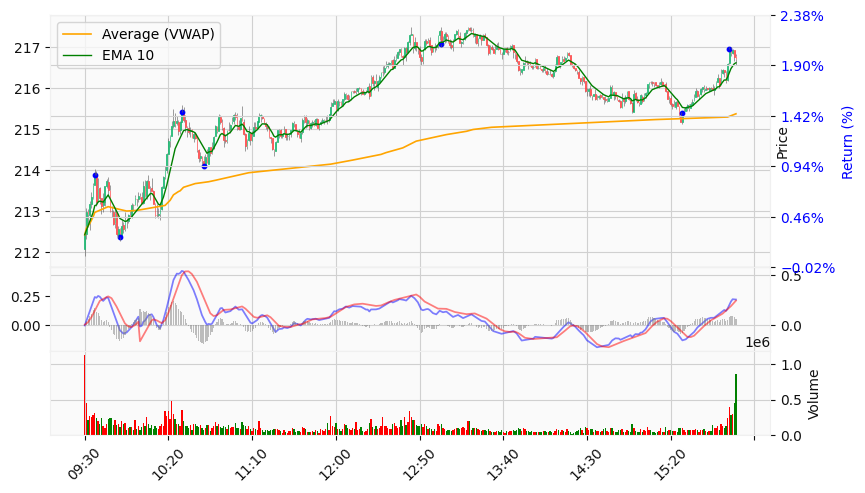

In [49]:
from PlotPlus import PlotPlus
idx = 37
daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')

while True:
    date = daily.iloc[idx]['date']
    print(idx, date)
    idx += 1
    df = ba.get_historical_data(ba.contracts[0], date)
    st = Trend(ba.contracts[0], ba.pm)
    df = st.setParams(df, window=8)
    
    pp = PlotPlus(df)
    pp.plot_basic(style_type="candle")
    # pp.mark_segment("slope_segment")
    pivot_point = df[df["pivot_group"]]
    pp.mark_point(pivot_point, "close")
    pp.mark_bs_point(ba.pm.trade_log)
    pp.show()
    
    break

In [44]:
df['pct_change'] = df['close'].pct_change()
df.head(20)

,date,open,high,low,close,volume,average,barCount,ema_10,group_id,pivot,pivot_group,pct_change
0,2024-07-01 09:30:00-04:00,212.09,212.52,211.92,212.43,1124368,212.066,2345,212.430000,0,True,False,NaN
1,2024-07-01 09:31:00-04:00,212.44,213.09,212.33,212.98,457214,212.734,2374,212.530000,0,False,False,0.002589
2,2024-07-01 09:32:00-04:00,213.02,213.07,212.61,212.94,211550,212.907,1161,212.604545,0,False,False,-0.000188
3,2024-07-01 09:33:00-04:00,212.92,213.26,212.55,213.18,275244,212.912,1131,212.709174,0,False,False,0.001127
4,2024-07-01 09:34:00-04:00,213.19,213.48,213.08,213.34,250397,213.305,1058,212.823869,0,False,True,0.000751
5,2024-07-01 09:35:00-04:00,213.33,213.70,213.31,213.65,278939,213.478,1075,212.974075,1,True,False,0.001453
6,2024-07-01 09:36:00-04:00,213.64,214.04,213.64,213.89,308684,213.906,1386,213.140607,1,True,True,0.001123
7,2024-07-01 09:37:00-04:00,213.88,213.98,213.14,213.23,246904,213.523,1083,213.156860,2,False,False,-0.003086
8,2024-07-01 09:38:00-04:00,213.24,213.81,213.22,213.57,200104,213.524,910,213.231976,2,False,False,0.001595
9,2024-07-01 09:39:00-04:00,213.57,213.60,213.18,213.33,162221,213.414,812,213.249799,2,False,False,-0.001124


In [ ]:
ba.statistic()

In [ ]:
ba.plot_pnl()

In [183]:
amp_pct = 0.004
window = 8

df_trend = identify_trend_groups_vectorized(df, amp_pct, window)
df_with_pivot = identify_pivots_by_group_vectorized(df_trend)

pd.set_option('display.max_rows', None)
# 查看部分结果
# print(df_with_pivot[['date', 'close', 'group_id', 'pivot', 'pivot_group']])

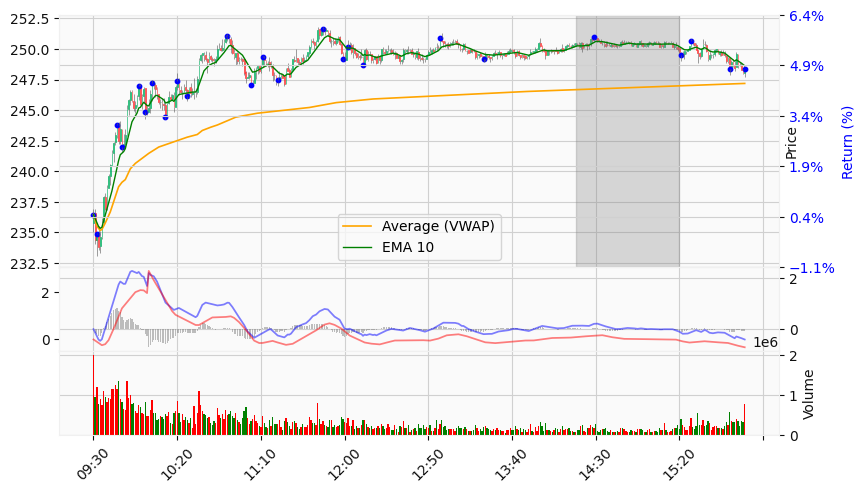

In [184]:
pp = PlotPlus(df)
pp.plot_basic(style_type="candle")
pp.mark_segment("slope_segment")
pp.mark_point(df_with_pivot[df_with_pivot["pivot_group"]], "close")
pp.mark_bs_point(ba.pm.trade_log)
pp.show()